In [18]:
from spleeter.separator import Separator
import os
import librosa
from swift_f0 import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [19]:
import tensorflow as tf

tf.config.threading.set_intra_op_parallelism_threads(
    tf.config.threading.get_intra_op_parallelism_threads() or 0
)
tf.config.threading.set_inter_op_parallelism_threads(2)

In [ ]:
# inputs
# audio_path = '/Users/saumyamishra/Desktop/intern/summer25/RagaDetection/RagaDataset/Hindustani/audio/Jog/Jog_10.mp3'
audio_path = '/Users/saumyamishra/Desktop/intern/summer25/RagaDetection/audio/marubihagavc.mp3'

output_dir = 'separated_stems'        # saved stems directory

filename = os.path.splitext(os.path.basename(audio_path))[0]
stem_dir = os.path.join(output_dir, filename)

# only run separation if the folder doesn't already exist
if not os.path.isdir(stem_dir):
    separator = Separator('spleeter:2stems')
    separator.separate_to_file(audio_path, output_dir)
else:
    print(f"Skipping separation: '{stem_dir}' already exists.")

# set the paths
vocals_path = os.path.join(stem_dir, 'vocals.wav')
accompaniment_path = os.path.join(stem_dir, 'accompaniment.wav')

print("Vocals:", vocals_path)
print("Accompaniment:", accompaniment_path)


Skipping separation: 'separated_stems/surdasi' already exists.
Vocals: separated_stems/surdasi/vocals.wav
Accompaniment: separated_stems/surdasi/accompaniment.wav


-------Vocal analysis--------


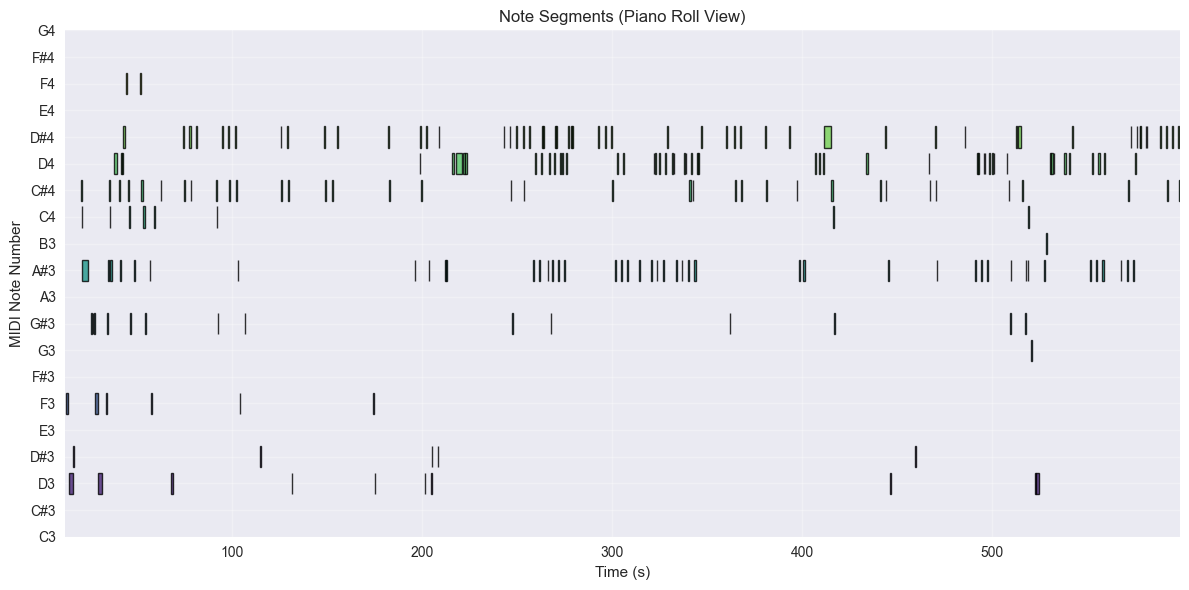

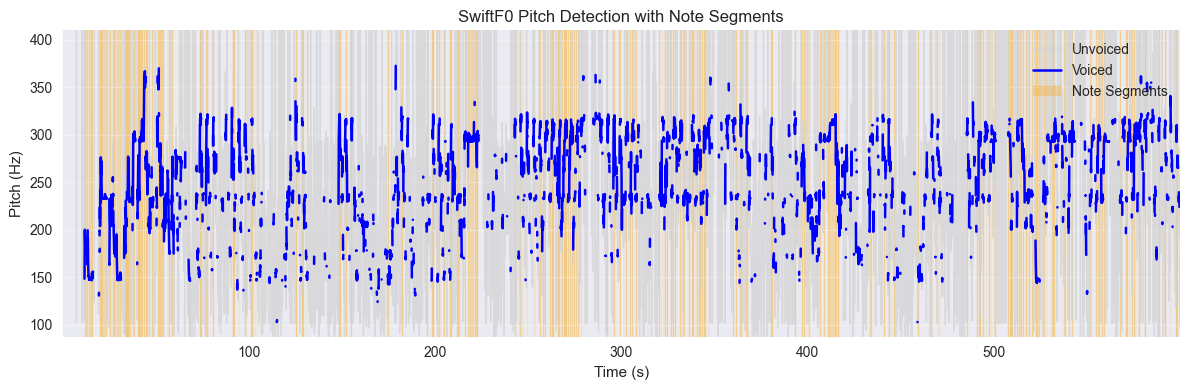

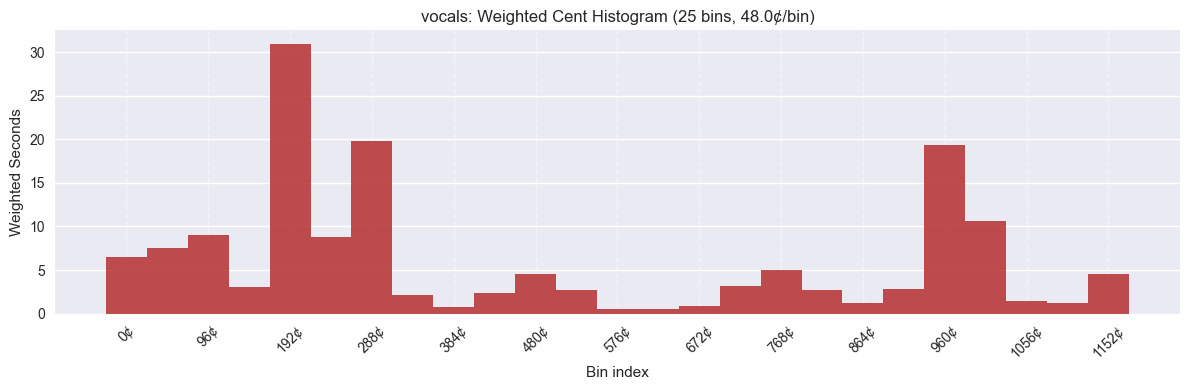

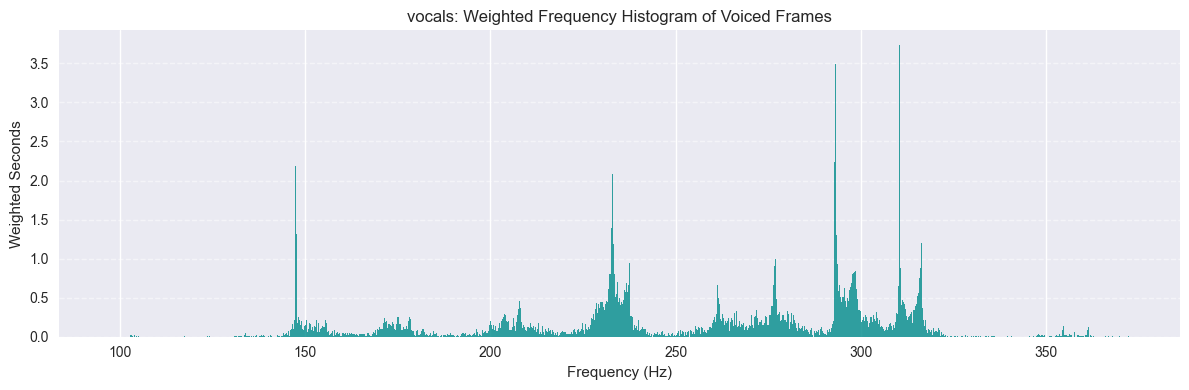

-------Accompaniment analysis --------


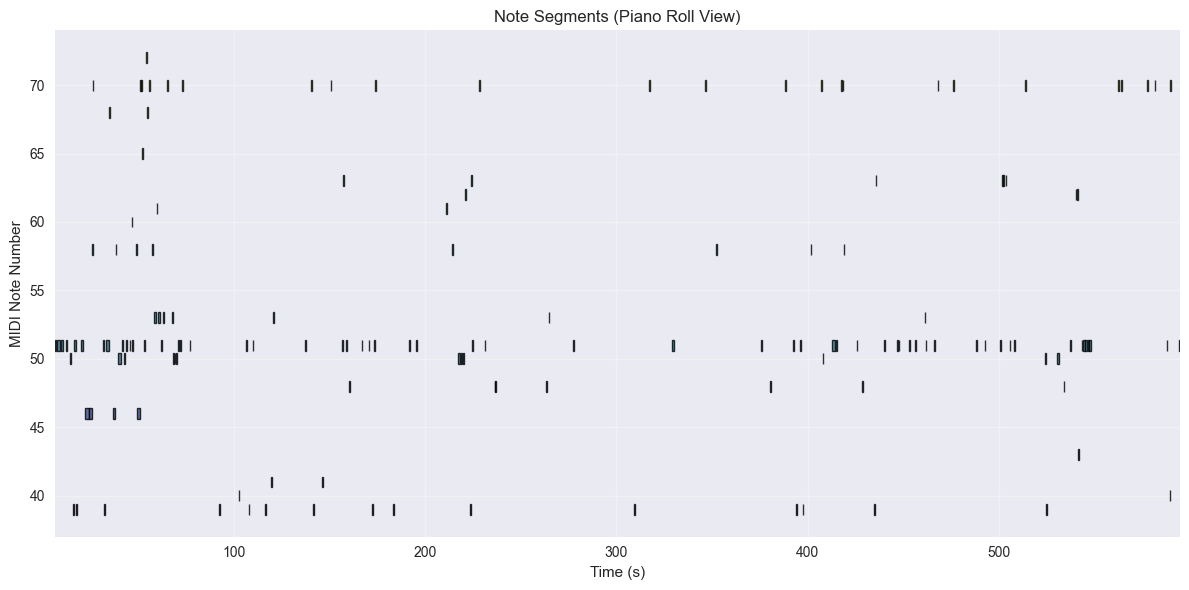

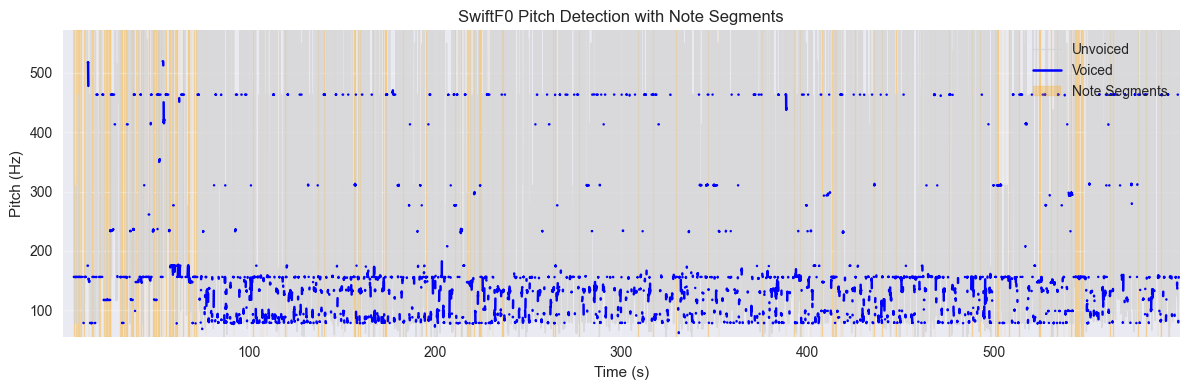

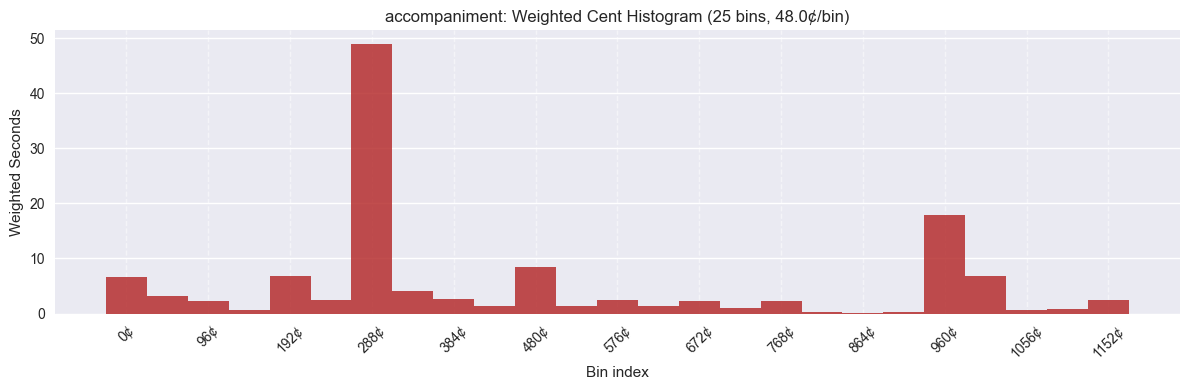

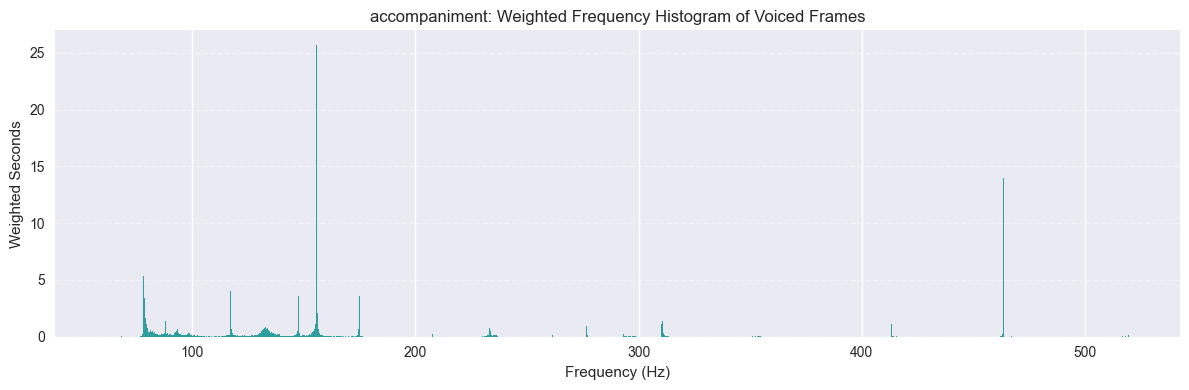

In [21]:
def analyze_audio_stem(stem_path, detector, output_prefix="output", num_bins=25):
    y, sr = librosa.load(stem_path, sr=None, duration=600.0)
    result = detector.detect_from_array(y, sr)

    # 1. Pitch plots + CSV
    plot_pitch(result, show=False, output_path=f"{output_prefix}_pitch.jpg")
    export_to_csv(result, f"{output_prefix}_pitch_data.csv")

    # 2. Note segmentation
    notes = segment_notes(
        result,
        split_semitone_threshold=0.8,
        min_note_duration=0.25
    )
    plot_notes(notes, output_path=f"{output_prefix}_note_segments.jpg")
    plot_pitch_and_notes(result, notes, output_path=f"{output_prefix}_combined_analysis.jpg")
    export_to_midi(notes, f"{output_prefix}_notes.mid")

    # 3. Extract voiced pitch/confidence
    voiced_mask = result.voicing
    voiced_frequencies = result.pitch_hz[voiced_mask]
    voiced_confidences = result.confidence[voiced_mask]

    # remove unvoiced / invalid
    valid_mask = voiced_frequencies > 0
    valid_frequencies = voiced_frequencies[valid_mask]
    valid_confidences = voiced_confidences[valid_mask]

    # frame duration from SwiftF0
    frame_duration = getattr(result, "frame_period", 1.0 / sr * 512)  # fallback if missing
    weights = valid_confidences * frame_duration

    # 4. Weighted cent histogram
    midi_vals = librosa.hz_to_midi(valid_frequencies)
    cent_values = (midi_vals % 12) * 100   # fold into one octave
    cent_hist, _ = np.histogram(
        cent_values,
        bins=num_bins,
        range=(0, 1200),
        weights=weights
    )
    bin_width = 1200 / num_bins

    # Weighted cent histogram
    plt.figure(figsize=(12, 4))
    plt.bar(np.arange(num_bins), cent_hist, width=1.0, color='firebrick', alpha=0.8)
    plt.title(f"{output_prefix}: Weighted Cent Histogram ({num_bins} bins, {bin_width:.1f}¢/bin)")
    plt.xlabel("Bin index")
    plt.ylabel("Weighted Seconds")
    step = max(1, num_bins // 12)
    ticks = np.arange(0, num_bins, step)
    labels = [f"{int(i * bin_width)}¢" for i in ticks]
    plt.xticks(ticks=ticks, labels=labels, rotation=45)
    plt.grid(axis='x', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.savefig(f"{output_prefix}_cent_histogram.jpg")
    plt.show()   # <--- display it
    plt.close()

    # Weighted frequency histogram
    plt.figure(figsize=(12, 4))
    plt.hist(
        valid_frequencies,
        bins=1200,
        color='darkcyan',
        alpha=0.8,
        weights=weights
    )
    plt.title(f"{output_prefix}: Weighted Frequency Histogram of Voiced Frames")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Weighted Seconds")
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.savefig(f"{output_prefix}_frequency_histogram.jpg")
    plt.show()   # <--- display it
    plt.close()


    if output_prefix == "vocals":
        return notes, result, valid_frequencies, cent_hist
    else:
        return notes, result, valid_frequencies


min_note_str = 'G1'
max_note_str = 'C5'
fmin_hz = librosa.note_to_hz(min_note_str)
fmax_hz = librosa.note_to_hz(max_note_str)
detector = SwiftF0(fmin=fmin_hz, fmax=fmax_hz, confidence_threshold=0.98)

print("-------Vocal analysis--------")
vocals_notes, result_v, valid_freqs_v, cent_hist_v = analyze_audio_stem(
    vocals_path,
    detector,
    output_prefix="vocals"
)

min_note_str = 'G1'
max_note_str = 'C5'
fmin_hz = librosa.note_to_hz(min_note_str)
fmax_hz = librosa.note_to_hz(max_note_str)
detector = SwiftF0(fmin=fmin_hz, fmax=fmax_hz, confidence_threshold=0.8)

print("-------Accompaniment analysis --------")
accompaniment_notes, result_a, valid = analyze_audio_stem(
    accompaniment_path,
    detector,
    output_prefix="accompaniment"
)

# if accompaniment came back empty, retry with a lower confidence threshold
if not accompaniment_notes:
    print("No accompaniment notes found; lowering confidence threshold")
    fmin_hz = 65.0   
    fmax_hz = 2093.75
    detector = SwiftF0(fmin=fmin_hz, fmax=fmax_hz, confidence_threshold=0.8)
    accompaniment_notes, result_a, valid = analyze_audio_stem(
        accompaniment_path,
        detector,
        output_prefix="accompaniment"
    )
    if accompaniment_notes:
        print(f"retry succeeded: found {len(accompaniment_notes)} notes.")
    else:
        print("Retry still returned no notes.")

Successfully built the new interval-based rāga database.
Computed high-resolution histogram with shape: (100,)
Computed low-resolution histogram with shape: (25,)
Generating *normalized* histogram plot with Western-note x-axis and ±35¢ note zones...


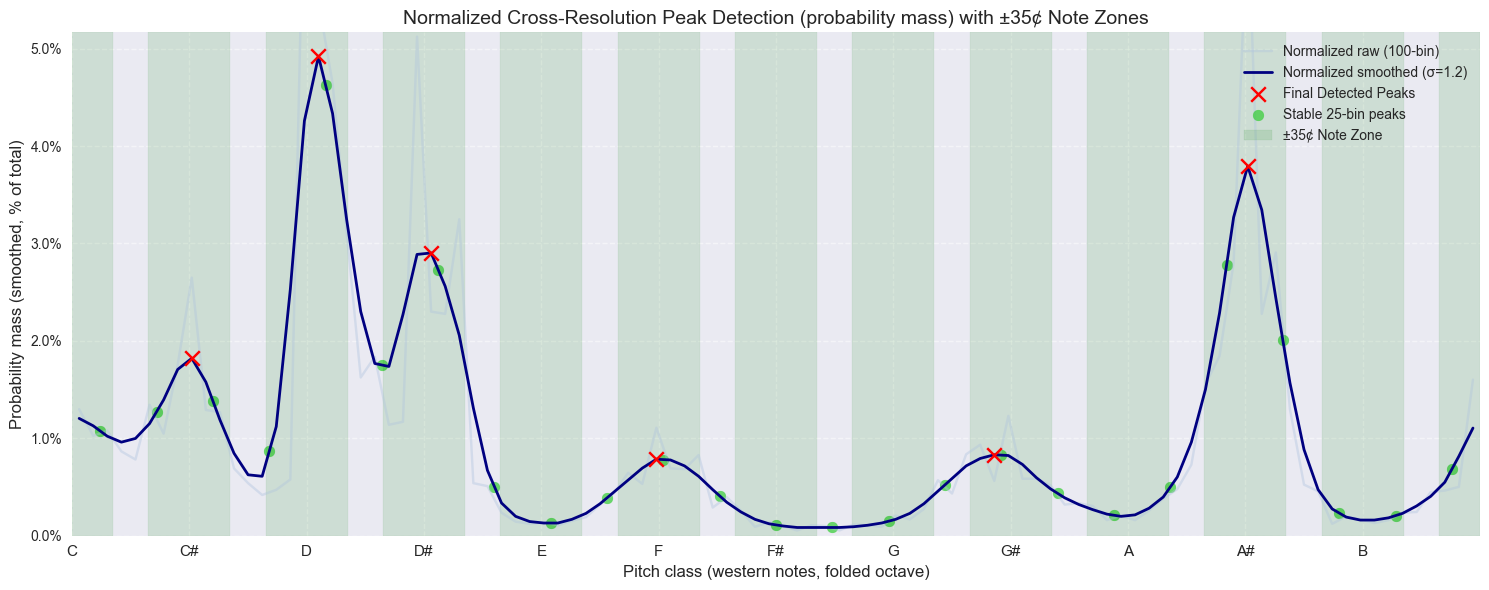


Found 7 precise peaks (100-bin) and 6 stable regions (25-bin).
Validated 6 final peaks.
Pitch-class candidates passed to next stage (±35¢ rule): [1, 2, 3, 5, 8, 10]


In [22]:
import librosa
from collections import defaultdict

# The canonical form is the lexicographically smallest rotation of the pattern.
def get_canonical_intervals(intervals):
    if not isinstance(intervals, tuple) or not intervals:
        return tuple()
    return min(tuple(np.roll(intervals, i)) for i in range(len(intervals)))

# Load the processed rāga hash table
# This path should be the same as in your original code
raga_df = pd.read_csv('/Users/saumyamishra/Desktop/intern/summer25/RagaDetection/raga_list_final.csv')

#Build a new lookup: canonical interval pattern → list of matching rāgas
# Each rāga is stored as a dictionary containing its name and specific interval pattern
raga_interval_db = defaultdict(list)

for _, row in raga_df.iterrows():
    if 'mask' in raga_df.columns:
        mask_abs = tuple(map(int, row['mask'].split(',')))
        name = row['raga']
    else:
        mask_abs = tuple(int(row[str(i)]) for i in range(12))
        name = row['names']

    # Get the pitch classes (swaras) from the rāga's definition
    p = np.where(np.array(mask_abs) == 1)[0]
    if len(p) < 2:  # Rāga needs at least two notes
        continue
    
    p.sort()
    # Calculate the rāga's specific interval pattern
    intervals = tuple(np.mod(np.diff(np.concatenate((p, [p[0] + 12]))), 12))

    # Ensure the scale is valid (intervals sum to an octave)
    if sum(intervals) != 12:
        continue

    # Find the canonical representation for this rāga's scale structure
    canonical_pattern = get_canonical_intervals(intervals)
    
    # Store the rāga's info under its canonical pattern
    raga_interval_db[canonical_pattern].append({'name': name, 'intervals': intervals})

# For compatibility with subsequent cells, we rename our new db.
# The original 'raga_masks' is no longer used in its old form.
raga_masks = raga_interval_db
print("Successfully built the new interval-based rāga database.")

# MODIFIED Cell 6: Compute both High- and Low-Resolution Histograms

# --- Settings for peak detection ---
num_bins_high_res = 100   # For precise, smoothed peak finding
num_bins_low_res = 25     # For stable, raw peak region finding
sigma = 1.2             # Smoothing amount for the high-res histogram
peak_tolerance_cents = 30 # How close a high-res peak must be to a low-res peak (in cents)

# --- Histogram Calculations ---
midi_vals_mel = librosa.hz_to_midi(valid_freqs_v)
cent_values = (midi_vals_mel % 12) * 100

# Create the high-resolution histogram (100 bins)
H_mel_100, bin_edges_100 = np.histogram(cent_values, bins=num_bins_high_res, range=(0, 1200))

# Create the low-resolution histogram (25 bins)
H_mel_25, bin_edges_25 = np.histogram(cent_values, bins=num_bins_low_res, range=(0, 1200))

print(f"Computed high-resolution histogram with shape: {H_mel_100.shape}")
print(f"Computed low-resolution histogram with shape: {H_mel_25.shape}")

# Cell 7: Detect peaks to get pitch-class candidates
# REPLACEMENT for Cell 7: Cross-Resolution Peak Detection and Visualization

from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt

# --- Part A: Find Peaks in Both Histograms and Convert to Cents ---

# 1. Process the HIGH-RESOLUTION histogram to get precise peak candidates
smoothed_H_100 = gaussian_filter1d(H_mel_100, sigma=sigma, mode='wrap')
bin_centers_100 = (bin_edges_100[:-1] + bin_edges_100[1:]) / 2
smoothed_peaks_100_indices = []
for i in range(num_bins_high_res):
    prev, next = (i - 1) % num_bins_high_res, (i + 1) % num_bins_high_res
    if smoothed_H_100[i] > smoothed_H_100[prev] and smoothed_H_100[i] > smoothed_H_100[next]:
        smoothed_peaks_100_indices.append(i)
# Get the cent values of these precise peaks
smoothed_peaks_cents = bin_centers_100[smoothed_peaks_100_indices]

# map every high-res bin center (0..1200 cents) to a pitch-class 0..11
cent_to_pc = np.round(bin_centers_100 / 100.0).astype(int) % 12
# sanity check
assert len(cent_to_pc) == len(H_mel_100)


# 2. Process the LOW-RESOLUTION histogram to get stable validation regions
bin_centers_25 = (bin_edges_25[:-1] + bin_edges_25[1:]) / 2
raw_peaks_25_indices = []
for i in range(num_bins_low_res):
    prev, next = (i - 1) % num_bins_low_res, (i + 1) % num_bins_low_res
    if H_mel_25[i] > H_mel_25[prev] and H_mel_25[i] > H_mel_25[next]:
        raw_peaks_25_indices.append(i)
# Get the cent values of these stable peaks
raw_peaks_cents = bin_centers_25[raw_peaks_25_indices]


# --- CONFIG (shared for all sections) ---
note_centers = np.arange(0, 1200, 100)  # Sa, re, Re, etc.
tolerance_cents = 35
peak_tolerance_cents = 30  # low/high-res match tolerance

# --- Part B: Validate Precise Peaks using Stable Peaks + ±35¢ Note Center Rule ---
final_peak_indices_100 = []
for i, sp_cent in zip(smoothed_peaks_100_indices, smoothed_peaks_cents):
    # Step 1: Check against stable low-res peaks
    is_validated = any(abs(sp_cent - rp_cent) <= peak_tolerance_cents for rp_cent in raw_peaks_cents)
    if not is_validated:
        continue

    # Step 2: Check against nearest ideal note center (±35¢ circular)
    diffs = np.abs((sp_cent - note_centers + 600) % 1200 - 600)
    if np.min(diffs) <= tolerance_cents:
        final_peak_indices_100.append(i)

import matplotlib.ticker as mtick

# --- NORMALIZED PLOTTING (replace previous Part C) ---
# Use the smoothed high-res data already computed (smoothed_H_100).
# Normalize the smoothed curve so it represents probability mass (sum -> 1).
smoothed_H_100_norm = smoothed_H_100.astype(float)
total = smoothed_H_100_norm.sum()
if total <= 0:
    smoothed_H_100_plot = smoothed_H_100_norm  # avoid division by zero
else:
    smoothed_H_100_plot = smoothed_H_100_norm / total

# Also compute a normalized raw curve for reference (optional)
H_mel_100_norm = H_mel_100.astype(float) / (H_mel_100.sum() + 1e-12)

print("Generating *normalized* histogram plot with Western-note x-axis and ±35¢ note zones...")

NOTE_NAMES = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
plt.figure(figsize=(15, 6))

# Plot normalized raw and normalized smoothed curves
plt.plot(bin_centers_100, H_mel_100_norm, color='lightsteelblue', alpha=0.4, label='Normalized raw (100-bin)')
plt.plot(bin_centers_100, smoothed_H_100_plot, color='navy', linewidth=2, label=f'Normalized smoothed (σ={sigma})')

# Plot final validated peaks (x positions same; y from normalized-smoothed curve)
peak_x_values = bin_centers_100[final_peak_indices_100]
peak_y_values_plot = smoothed_H_100_plot[final_peak_indices_100]
plt.scatter(peak_x_values, peak_y_values_plot, color='red', s=110, marker='x',
            zorder=6, label='Final Detected Peaks')

# Plot stable 25-bin low-res peak centers (map to normalized-smoothed y for display)
low_centers = bin_centers_25
low_vals_plot = np.interp(low_centers, bin_centers_100, smoothed_H_100_plot)
plt.scatter(low_centers, low_vals_plot, color='limegreen', s=60, marker='o', alpha=0.7, label='Stable 25-bin peaks')

# Draw ±tolerance shaded bands for each note center
for idx, center in enumerate(note_centers):
    low = (center - tolerance_cents) % 1200
    high = (center + tolerance_cents) % 1200
    if low < high:
        plt.axvspan(low, high, color='green', alpha=0.12, label='±35¢ Note Zone' if idx == 0 else "")
    else:
        plt.axvspan(0, high, color='green', alpha=0.12, label='±35¢ Note Zone' if idx == 0 else "")
        plt.axvspan(low, 1200, color='green', alpha=0.12)

# X-axis: Western note labels at every 100 cents (0..1100)
xticks_positions = np.arange(0, 1200, 100)
plt.xticks(ticks=xticks_positions, labels=NOTE_NAMES, fontsize=11)

# Y-axis: show probability mass as percentage (sum of smoothed curve = 1)
ax = plt.gca()
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))  # 0..1 -> 0%..100%
plt.ylabel("Probability mass (smoothed, % of total)", fontsize=12)

plt.title("Normalized Cross-Resolution Peak Detection (probability mass) with ±35¢ Note Zones", fontsize=14)
plt.xlabel("Pitch class (western notes, folded octave)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

# Legend: avoid duplicates
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='upper right')

plt.xlim(0, 1200)
plt.ylim(0, max(smoothed_H_100_plot.max() * 1.05, 0.01))  # small lower bound to keep scale visible
plt.tight_layout()
plt.show()



# --- Part D: Final Output for Downstream Cells ---
final_peak_cents = bin_centers_100[final_peak_indices_100]
pc_cand = set()

for cent_val in final_peak_cents:
    diffs = np.abs((cent_val - note_centers + 600) % 1200 - 600)  # circular diff
    nearest_idx = np.argmin(diffs)
    if diffs[nearest_idx] <= tolerance_cents:
        pc_cand.add(nearest_idx % 12)  # pitch class index

pc_cand = sorted(pc_cand)

cent_to_pc = np.round(bin_centers_100 / 100).astype(int) % 12
pc_cand = sorted(list({cent_to_pc[i] for i in final_peak_indices_100}))

print(f"\nFound {len(smoothed_peaks_cents)} precise peaks (100-bin) and {len(raw_peaks_cents)} stable regions (25-bin).")
print(f"Validated {len(final_peak_indices_100)} final peaks.")
print(f"Pitch-class candidates passed to next stage (±{tolerance_cents}¢ rule): {pc_cand}")



In [23]:
# Cell 8: Build interval sequence from detected pitch-classes
P = np.array(pc_cand)
p = np.sort(P)
k = len(p)
intervals = np.mod(np.diff(np.concatenate((p, [p[0]+12]))), 12)
print(f"Detected intervals: {intervals}")

# Helper function (repeat from above, or define in a shared cell)
def get_canonical_intervals(intervals):
    if not isinstance(intervals, tuple) or not intervals:
        return tuple()
    return min(tuple(np.roll(intervals, i)) for i in range(len(intervals)))

dx_candidates = []  # list of (tonic, mask_rel, ragas)

# p is the sorted list of detected pitch classes from Cell 8
# intervals is the detected interval sequence from Cell 8
# k is the number of detected pitch classes from Cell 8
for j in range(k):
    tonic = int(p[j])
    # Consider each possible rotation of the detected intervals
    rotated_I = tuple(np.roll(intervals, -j))
    
    # Find the canonical form of the detected interval pattern
    canonical_I = get_canonical_intervals(rotated_I)

    # Look for this scale structure in our new database
    if canonical_I in raga_masks:
        # We found a potential match! Now, find the specific rāgas.
        # 'raga_group' contains all rāgas matching the canonical pattern (e.g., Bhupali, Dhani)
        raga_group = raga_masks[canonical_I]
        
        # Check which of these rāgas has the exact interval pattern we just detected
        matching_ragas = [
            raga['name'] for raga in raga_group 
            if raga['intervals'] == rotated_I
        ]
        
        if matching_ragas:
            # We have a valid candidate. Now, construct the relative mask
            # that subsequent cells expect.
            current_note = 0
            # Notes relative to the tonic at 0
            relative_notes = {0}
            for step in rotated_I[:-1]:
                current_note += step
                relative_notes.add(current_note)
            
            mask_rel = tuple(1 if i in relative_notes else 0 for i in range(12))
            
            # Add the found candidate(s) to our list
            dx_candidates.append((tonic, mask_rel, matching_ragas))

print(f"Valid interval-based inversions: {[(t, ragas) for t,_,ragas in dx_candidates]}")

# Cell 10: Compute accompaniment tonic salience for these tonics
midi_vals_acc = librosa.hz_to_midi(valid)
pitch_classes_acc = np.mod(np.round(midi_vals_acc), 12).astype(int)

H_acc, _ = np.histogram(pitch_classes_acc, bins=12, range=(0,12))
a_theta = {t: np.roll(H_acc, -t)[0] for t,_,_ in dx_candidates}
print(f"Accompaniment salience per tonic: {a_theta}")
Theta_prime = [t for t,a in a_theta.items() if a >= 0]

results = []
# Pre-aggregate melody histogram from high-resolution bins to 12 pitch classes
H_pc = np.zeros(12, dtype=int)
# cent_to_pc is from the peak detection cell (Cell 7)
# H_mel_100 is from the histogram creation cell (Cell 6)
for bin_index, pc in enumerate(cent_to_pc):
    H_pc[pc] += H_mel_100[bin_index] # CORRECTED

for tonic, mask_rel, ragas in dx_candidates:
    # Skip candidates whose tonic has weak support from the accompaniment
    if tonic not in Theta_prime:
        continue
    
    # create Sa-relative view of the melody's pitch distribution
    H_rot = np.roll(H_pc, -tonic)
        
    # bonus for the tonic (Sa) is always its count in the melody
    sa_bonus = H_rot[0]
    
    bonus_options = [0] # Start with 0 in case rāga has no Ma or Pa.
    if mask_rel[5] == 1:  # Check for Shuddha Ma
        bonus_options.append(H_rot[5])
    if mask_rel[6] == 1:  # Check for Tivra Ma
        bonus_options.append(H_rot[6])
    if mask_rel[7] == 1:  # Check for Pa
        bonus_options.append(H_rot[7])
    
    dominant_note_bonus = max(bonus_options)
    

    score = sa_bonus + dominant_note_bonus
        
    for raga in ragas:
        results.append({'tonic': tonic, 'raga': raga,
                        'score': score, 'salience': a_theta[tonic]})

#results sorted by Salience, then Score

if results:
    df = pd.DataFrame(results)
    print("Top 10 Rāga Candidates (Ranked by Tonic Salience, then Score):")
    
    final_ranking = df.sort_values(by=['salience', 'score'], ascending=[False, False])
    
    print(final_ranking.head(10))
else:
    print(" No matching ragas were found in the database.")

Detected intervals: [1 1 2 3 2 3]
Valid interval-based inversions: [(1, ['[“Jayat"]']), (2, ['[“Gurjari Todi"]']), (3, ['["Sarang"]']), (10, ['["Jog"]'])]
Accompaniment salience per tonic: {1: 509, 2: 715, 3: 4985, 10: 2313}
Top 10 Rāga Candidates (Ranked by Tonic Salience, then Score):
   tonic              raga  score  salience
2      3        ["Sarang"]   5011      4985
3     10           ["Jog"]   5011      2313
1      2  [“Gurjari Todi"]   3942       715
0      1         [“Jayat"]   2216       509


In [24]:
# ---------------- Replacement scoring cell: alignment fixed, fully normalized, diagnostics exposed ----------------
import numpy as np
import pandas as pd

# ---------------- Tunables ----------------
EPS = 1e-12
ALPHA_MATCH = 0.40
BETA_PRESENCE = 0.25
GAMMA_LOGLIKE = 0.15
DELTA_EXTRA = 1.10
COMPLEX_PENALTY = 0.5
USE_PRESENCE_SUM_DIV_SQRT = True    # i.e. observed_note_score = sum(p_rescaled)/sqrt(size)
MATCH_SIZE_GAMMA = 0.25
TONIC_SALIENCE_WEIGHT = 0.12
SCALE = 1000.0
USE_PRESENCE_MEAN = False
USE_NORM_PRIMARY = True

# ---------------- Inputs ----------------
H_pc_arr = np.array(H_pc, dtype=float)
p_pc = (H_pc_arr + EPS) / (np.sum(H_pc_arr) + 12*EPS)

midi_vals_acc_arr = np.asarray(midi_vals_acc)
pitch_classes_acc = np.mod(np.round(midi_vals_acc_arr), 12).astype(int)
H_acc, _ = np.histogram(pitch_classes_acc, bins=12, range=(0, 12))
salience_all_tonics = {t: int(H_acc[t]) for t in range(12)}
max_acc = float(H_acc.max()) if H_acc.size and H_acc.max() > 0 else 1.0

final_results = []

# ---------------- Raga Scoring ----------------
for idx, row in raga_df.iterrows():
    # robust mask extraction
    mask_abs = None
    if 'mask' in raga_df.columns and pd.notna(row.get('mask')):
        raw = row['mask']
        if isinstance(raw, str):
            parts = [x.strip() for x in raw.split(',') if x.strip()]
            mask_abs = tuple(int(x) for x in parts)
        else:
            try:
                mask_abs = tuple(int(x) for x in list(raw))
            except Exception:
                mask_abs = None
    if mask_abs is None:
        try:
            mask_abs = tuple(int(row[i]) for i in range(12))
        except Exception:
            try:
                mask_abs = tuple(int(row[str(i)]) for i in range(12))
            except Exception:
                continue

    name = row.get('names') if 'names' in raga_df.columns else row.get('raga', f"raga_{idx}")
    mask_abs = np.array(mask_abs, dtype=int)
    if mask_abs.sum() < 2:
        continue

    # absolute mask: fixed; rotate only observed distribution
    for tonic in range(12):
        p_rot = np.roll(p_pc, -tonic)
        raga_note_indices = np.where(mask_abs == 1)[0].tolist()
        raga_size = len(raga_note_indices)
        if raga_size < 2:
            continue

        # probability masses
        match_mass = float(np.sum(p_rot[raga_note_indices]))
        extra_mass = float(1.0 - match_mass)

        # presence
        peak = float(np.max(p_rot) + EPS)
        pres = (p_rot[raga_note_indices] / peak)
        if USE_PRESENCE_MEAN:
            observed_note_score = float(np.mean(pres)) if raga_size > 0 else 0.0
        else:
            observed_note_score = float(np.sum(pres) / (np.sqrt(raga_size) + EPS))

        # log-likelihood
        sum_logp = float(np.sum(np.log(p_rot[raga_note_indices] + EPS)))
        baseline = -np.log(12.0)
        avg_logp = sum_logp / (raga_size + EPS)
        loglike_norm = 1.0 + (avg_logp / (-baseline + EPS))
        loglike_norm = max(0.0, min(1.0, loglike_norm))

        # complexity penalty
        complexity_pen = max(0.0, (raga_size - 5) / 12.0)

        # primary score
        if USE_NORM_PRIMARY:
            prim = float(p_rot[0])
            bonus_options = [0.0]
            if mask_abs[5] == 1: bonus_options.append(float(p_rot[5]))
            if mask_abs[6] == 1: bonus_options.append(float(p_rot[6]))
            if mask_abs[7] == 1: bonus_options.append(float(p_rot[7]))
            primary_score_norm = prim + max(bonus_options)
        else:
            H_rot_counts = np.roll(H_pc_arr, -tonic)
            sa_bonus = float(H_rot_counts[0])
            bonus_options = [0.0]
            if mask_abs[5] == 1: bonus_options.append(float(H_rot_counts[5]))
            if mask_abs[6] == 1: bonus_options.append(float(H_rot_counts[6]))
            if mask_abs[7] == 1: bonus_options.append(float(H_rot_counts[7]))
            primary_score_norm = sa_bonus + max(bonus_options)

        # combine components
        fit_norm = (ALPHA_MATCH * match_mass +
                    BETA_PRESENCE * observed_note_score +
                    GAMMA_LOGLIKE * loglike_norm) - (
                    DELTA_EXTRA * extra_mass +
                    COMPLEX_PENALTY * complexity_pen)

        # accompaniment salience
        tonic_sal = float(salience_all_tonics.get(tonic, 0))
        tonic_sal_norm = tonic_sal / (max_acc + EPS)
        fit_norm += TONIC_SALIENCE_WEIGHT * tonic_sal_norm

        fit_norm = max(-1.0, min(1.0, fit_norm))
        fit_score = float(fit_norm * SCALE)

        final_results.append({
            'raga': name,
            'tonic': int(tonic),
            'salience': int(tonic_sal),
            'fit_score': fit_score,
            'primary_score': float(primary_score_norm),
            'match_mass': match_mass,
            'extra_mass': extra_mass,
            'observed_note_score': observed_note_score,
            'loglike_norm': loglike_norm,
            'raga_size': raga_size
        })

# ---------------- Output ----------------
if final_results:
    df_final = pd.DataFrame(final_results)
    final_ranking = df_final.sort_values(by=['salience', 'fit_score', 'primary_score'],
                                         ascending=[False, False, False])
    print(final_ranking.head(80).to_string(index=True))
else:
    print("Analysis complete: No plausible rāga candidates were found.")


                                                                                 raga  tonic  salience   fit_score  primary_score  match_mass  extra_mass  observed_note_score  loglike_norm  raga_size
651                                                                ["Surdasi Malhar"]      3      4985  683.926611       0.380399    0.912852    0.087148             1.441949      0.116631          7
519                  ["Alhaiya Bilawal, Bihagda, Desh, Devgiri Bilawal, Gaud Malhar"]      3      4985  633.756474       0.380399    0.928642    0.071358             1.372151      0.018373          8
387                          ["Bahar, Lanka Dahan Sarang, Miyan ki Malhar, Sindhura"]      3      4985  625.530952       0.380399    0.925226    0.074774             1.367103      0.006110          8
687                                                                        ["Sarang"]      3      4985  618.498857       0.380399    0.840052    0.159948             1.433273      0.145133          6


/var/folders/dr/7jrw49755h70bsy03x6hy14c0000gn/T/ipykernel_1588/1501318006.py:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mask_abs = tuple(int(row[i]) for i in range(12))
